In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
import torchvision, numpy as np

In [2]:
batch_size = 64 if torch.cuda.is_available() else 16

### datasets and dataloaders

In [3]:

transforms = tfs.Compose([
    tfs.RandomCrop(32, padding=4),    
    tfs.RandomHorizontalFlip(),         
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465),
                  (0.247, 0.2435, 0.2616))
])


train_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=True,
    transform=transforms,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


test_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=False,
    transform=transforms,
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3276\618654969.py:11: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3276\618654969.py:21: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


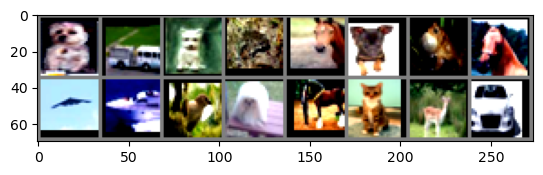

dog   truck dog   frog  horse dog   frog  horse plane ship  bird  dog   horse cat   deer  car  


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions for showing an image :
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### Residual Blocks and Residual Networks

In [ ]:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, filters):
        super(IdentityBlock, self).__init__()
        F1, F2, F3 = filters

        # Main Path - Layer 1
        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu1 = nn.ReLU(inplace=True)

        # Main Path - Layer 2
        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu2 = nn.ReLU(inplace=True)

        # Main Path - Layer 3
        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(F3)
        self.final_relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x_shortcut = x
        
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        x += x_shortcut
        x = self.final_relu(x)

        return x        

In [ ]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=2):
        super(ConvolutionalBlock, self).__init__()
        F1, F2, F3 = filters

        # main path (layer 1)
        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu1 = nn.ReLU(inplace=True)

        # main path (layer 2)
        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu2 = nn.ReLU(inplace=True)

        # main path (layer 3)
        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(F3)

        # Shortcut Path
        self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn_shortcut = nn.BatchNorm2d(F3)

        self.final_relu = nn.ReLU(inplace=True)
    
    
    def forward(self, x):
        x_shortcut = x

        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        x_shortcut = self.bn_shortcut(self.conv_shortcut(x_shortcut))

        x += x_shortcut
        x = self.final_relu(x)

        return x

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(ResNet50, self).__init__()

        # Stage 1
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        
        # Stage 1
        self.stage1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Stage 2
        self.stage2 = nn.Sequential(
            ConvolutionalBlock(in_channels=64, filters=[64, 64, 256], stride=1),
            IdentityBlock(in_channels=256, filters=[64, 64, 256]),
            IdentityBlock(in_channels=256, filters=[64, 64, 256])
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            ConvolutionalBlock(in_channels=256, filters=[128, 128, 512], stride=2),
            IdentityBlock(in_channels=512, filters=[128, 128, 512]),
            IdentityBlock(in_channels=512, filters=[128, 128, 512]),
            IdentityBlock(in_channels=512, filters=[128, 128, 512]),
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            ConvolutionalBlock(in_channels=512, filters=[256, 256, 1024], stride=2),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024]),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024]),
        )


        # Final Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # stage 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Stages 2-4
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final layers
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = ResNet50(in_channels=3, num_classes=10)
model = model.to(device)

In [ ]:
optim = torch.optim.SGD(model.parameters(),
                        lr=0.01,
                        momentum=0.9,
                        weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_set(model, train_dataloader, loss_fn, optim, device):
    running_loss, correct = 0.0, 0
    model.train()
    for x, y  in train_dataloader:
        # print(f"Batch {batch_idx}")  # Debug line
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)

        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float64).sum().item()
    return running_loss / len(train_dataloader), (correct / len(train_dataloader.dataset)) * 100

In [ ]:
def train_data(model, train_dataloader, loss_fn, optim, device, epochs):
    training_losses, training_accs = [], []
    for epoch in range(1, epochs + 1):
        # print(f"hello {epoch}")
        train_loss, train_acc = train_set(model, train_dataloader, loss_fn, optim, device)
        print(f"Epoch {epoch} / {epochs} => loss : {train_loss:.3f} ; accuracy : {train_acc:.3f}%")
        training_losses.append(train_loss)
        training_accs.append(train_acc)
    return training_losses, training_accs

In [12]:
train_data(model, train_dataloader, loss_fn, optim, device, 10)

Epoch 1 / 10 => loss : 1.519 ; accuracy : 43.704%
Epoch 2 / 10 => loss : 1.085 ; accuracy : 61.434%
Epoch 3 / 10 => loss : 0.904 ; accuracy : 68.346%
Epoch 4 / 10 => loss : 0.786 ; accuracy : 72.616%
Epoch 5 / 10 => loss : 0.709 ; accuracy : 75.462%
Epoch 6 / 10 => loss : 0.651 ; accuracy : 77.608%
Epoch 7 / 10 => loss : 0.607 ; accuracy : 79.138%
Epoch 8 / 10 => loss : 0.573 ; accuracy : 80.346%
Epoch 9 / 10 => loss : 0.543 ; accuracy : 81.374%
Epoch 10 / 10 => loss : 0.515 ; accuracy : 82.348%


([1.5191510927391052,
  1.0848846452713012,
  0.9042661555242538,
  0.7861315541219711,
  0.7087321761846542,
  0.6508858174562454,
  0.6073792796683312,
  0.5729695791435242,
  0.5431913731247187,
  0.5153349725341797],
 [43.704,
  61.434,
  68.34599999999999,
  72.616,
  75.46199999999999,
  77.608,
  79.13799999999999,
  80.34599999999999,
  81.374,
  82.348])

In [13]:
def test_set(model, data_loader, loss_fn, device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            running_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float64).sum().item()
        return running_loss / len(data_loader), (correct / len(data_loader.dataset)) * 100

In [14]:
test_set(model, test_dataloader, loss_fn, device)

(0.517870956337452, 82.36)

In [ ]:
torch.save(model.state_dict(), 'resnet50.pth')